In [75]:
import neurite as ne
import sys
import nibabel as nib
from tensorflow.keras.models import load_model
from neurite_sandbox.tf.models import labels_to_labels
import nibabel as nib
import tqdm
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm
from utils import *
import pathlib
import surfa as sf


feta = pathlib.Path('/autofs/space/bal_004/users/jd1677/synthstrip/feta_3d')
files = list(feta.glob('sub-???/anat/sub-???_rec-mial_dseg.nii.gz'))
label_maps = [np.uint8(f.dataobj) for f in map(nib.load, files)]

labels = np.unique(label_maps)
num_labels=8

def segment_brain(image, brain_mask, labels_in):
    label_map = np.zeros_like(image, dtype=np.uint8)
    unique_intensities = np.unique(image[brain_mask == 1])
    label_map[image == unique_intensities] = labels_in[:max(labels)]
    label_map[image == unique_intensities] = labels_in[max(labels):]
    return label_map



In [76]:
image = sf.load_volume('example/mom_010_22_week_2__body_T2_Hast_mm_400_FOV/22_week_2__body_T2_Hast_mm_400_FOV.mgz')
mask  = sf.load_volume('example/mom_010_22_week_2__body_T2_Hast_mm_400_FOV/manual_masks_b2_mom_010_22_week_2__body_T2_Hast_mm_400_FOV_segment.nii.gz')

In [77]:

labels_in = range(max(labels) + num_labels + 1)
print(labels_in)

range(0, 16)


In [78]:
from sklearn.cluster import KMeans
def minmax_norm(x):
    x = np.asarray(x,  dtype=np.float32)
    x_min = np.min(x)
    x_max = np.max(x)#, axis=axis, keepdims=True)
    return (x - x_min) / (x_max - x_min)


def segment_brain(image, brain_mask, labels_in):
    # Flatten the image for K-Means clustering
    image = minmax_norm(image)
    image[image<0.02]=0
    flattened_ibrain = image[brain_mask == 1].reshape(-1, 1)

    num_clusters = 8#len(labels_in)

    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(flattened_ibrain)

    brain_map = np.zeros_like(image, dtype=np.uint8)
    brain_map[brain_mask == 1] = kmeans.labels_ #+ 1  # Adding 1 to start labels from 1

    flattened_FOV = image[brain_mask == 0].reshape(-1, 1)

    num_clusters = len(labels_in) - num_clusters #len(labels_in)

    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(flattened_FOV)

    FOV_map = np.zeros_like(image, dtype=np.uint8)
    FOV_map[mask == 0] = kmeans.labels_ +num_clusters#+ #+ 1  # Adding 1 to start labels from 1
    
    FOV_map = FOV_map + brain_map
    FOV_map[image==0]=0
    return FOV_map

fetus_label_map = segment_brain(image, mask, labels_in)

In [79]:
nifti_img = sf.Volume(fetus_label_map)#nib.Nifti1Image(prediction.astype(np.float32), affine=np.eye(4))  # Assuming identity affine for simplicity
nifti_img.geom = image.geom
nifti_img = nifti_img.resample_like(image)
nifti_img.astype(np.int32).save("output/fetus.nii.gz")

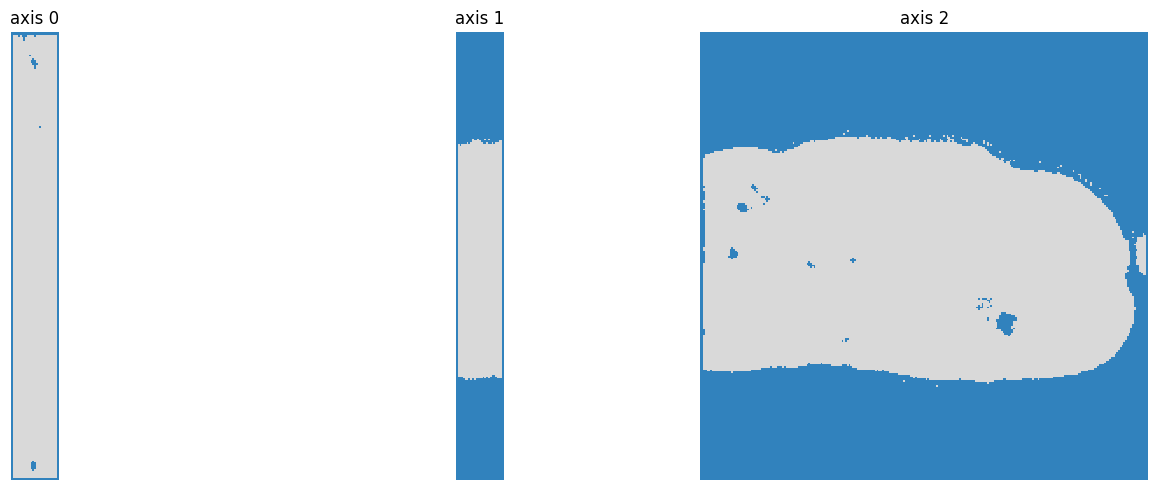

In [80]:
from scipy.ndimage import binary_closing

def fill_holes(label_map, iterations=1):
    closed_map = binary_closing(label_map, iterations=iterations)
    return closed_map.astype(np.uint8)

# Usage
filled_label_map = fill_holes(fetus_label_map, iterations=1)
ne.plot.volume3D(filled_label_map, cmaps=['tab20c'])

In [81]:
# nifti_img = sf.Volume(smoothed_fetus_label_map)#nib.Nifti1Image(prediction.astype(np.float32), affine=np.eye(4))  # Assuming identity affine for simplicity
# nifti_img.geom = image.geom
# nifti_img = nifti_img.resample_like(image)
# nifti_img.astype(np.int32).save("output/smoothed_fetus.nii.gz")

In [82]:
import surfa as sf
import os
import os
import glob
import nibabel as nib
import numpy as np
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter
from scipy.ndimage import binary_erosion, binary_dilation
from scipy.ndimage.measurements import label
from scipy.stats import mode

def minmax_norm(x):
    x = np.asarray(x,  dtype=np.float32)
    x_min = np.min(x)
    x_max = np.max(x)#, axis=axis, keepdims=True)
    return (x - x_min) / (x_max - x_min)
    
def segment_brain_with_ring(image, brain_mask, labels_in):
    image = gaussian_filter(image.astype(np.uint8), sigma=2.8)
    
    image_norm = minmax_norm(image)

    labeled_brain_mask, num_features = label(brain_mask)

    largest_component = np.argmax(np.bincount(labeled_brain_mask.flat)[1:]) + 1

    brain_mask = (labeled_brain_mask == largest_component).astype(np.uint8)
    
    
    flattened_ibrain = image_norm[brain_mask == 1].reshape(-1, 1)

    num_clusters1 = 7 # len(labels_in)

    kmeans = KMeans(n_clusters=num_clusters1, random_state=0).fit(flattened_ibrain)

    brain_map = np.zeros_like(image, dtype=np.uint8)
    brain_map[brain_mask == 1] = kmeans.labels_ + 1  
    brain_map[(brain_mask == 1) & (brain_map == 0)] = 1

    expanded_ring = binary_dilation(brain_mask.astype(bool))
    
    # Apply additional smoothing to the binary dilation result
    smoothed_ring = gaussian_filter(expanded_ring.astype(np.float32), sigma=4.0)
    
    # Threshold the smoothed ring to obtain a smoother transition
    ring_mask = (smoothed_ring > 0.5).astype(np.uint8)
    
    brain_map[ring_mask] = 8  # You can use any non-zero label for the ring
    brain_map[(brain_mask == 1) & (brain_map == 0)] = 1
    

    return brain_map


def segment_FOV(image, brain_mask, labels_in):
    image = gaussian_filter(image.astype(np.uint8), sigma=2.8)
    
    image_norm = minmax_norm(image)

    labeled_brain_mask, num_features = label(brain_mask)

    largest_component = np.argmax(np.bincount(labeled_brain_mask.flat)[1:]) + 1

    brain_mask = (labeled_brain_mask == largest_component).astype(np.uint8)

    flattened_ibrain = image_norm[brain_mask == 1].reshape(-1, 1)

    num_clusters1 = 7

    kmeans = KMeans(n_clusters=num_clusters1, random_state=0).fit(flattened_ibrain)

    brain_map = np.zeros_like(image, dtype=np.uint8)
    brain_map[brain_mask == 1] = kmeans.labels_ + 1 


    flattened_FOV = image_norm[brain_mask == 0].reshape(-1, 1)

    num_clusters2 = len(labels_in) - num_clusters1 

    kmeans = KMeans(n_clusters=num_clusters2, random_state=0).fit(flattened_FOV)

    FOV_map = np.zeros_like(image, dtype=np.uint8)
    FOV_map[brain_mask == 0] = kmeans.labels_ +num_clusters1 + 1
    
    FOV_map = FOV_map + brain_map
    FOV_map[image==0]=0
    FOV_map[(brain_mask == 1) & (FOV_map == 0)] = 1

    return FOV_map

import numpy as np
from scipy.ndimage import label
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import minmax_scale
from scipy.ndimage import gaussian_filter

def segment_FOV_GMM(image, brain_mask, labels_in):
    image = gaussian_filter(image.astype(np.uint8), sigma=2.8)

    # Reshape the 3D image to a 1D array
    image_flattened = image.flatten().reshape(-1, 1)

    # Normalize the flattened image
    image_norm = minmax_scale(image_flattened)

    labeled_brain_mask, num_features = label(brain_mask)

    largest_component = np.argmax(np.bincount(labeled_brain_mask.flat)[1:]) + 1

    brain_mask = (labeled_brain_mask == largest_component).astype(np.uint8)

    flattened_ibrain = image_norm[brain_mask.flatten() == 1].reshape(-1, 1)

    num_clusters1 = 7

    gmm = GaussianMixture(n_components=num_clusters1, max_iter=500, covariance_type='full').fit(flattened_ibrain)

    brain_map = np.zeros_like(image, dtype=np.uint8)
    brain_map[brain_mask == 1] = gmm.predict(flattened_ibrain) + 1 

    flattened_FOV = image_norm[brain_mask.flatten() == 0].reshape(-1, 1)

    num_clusters2 = len(labels_in) - num_clusters1 

    gmm = GaussianMixture(n_components=num_clusters2, max_iter=500, covariance_type='full').fit(flattened_FOV)

    FOV_map = np.zeros_like(image, dtype=np.uint8)
    FOV_map[brain_mask == 0] = gmm.predict(flattened_FOV) + num_clusters1 + 1
    
    FOV_map = FOV_map + brain_map
    FOV_map[image == 0] = 0
    FOV_map[(brain_mask == 1) & (FOV_map == 0)] = 1

    return FOV_map


# Usage
# filled_label_map = fill_holes(fetus_label_map, iterations=1)
def segment_brain_GMM(image, brain_mask, labels_in):
    image = gaussian_filter(image.astype(np.uint8), sigma=1.5)

    image_norm = minmax_scale(image.flatten().reshape(-1, 1))

    labeled_brain_mask, num_features = label(brain_mask)

    largest_component = np.argmax(np.bincount(labeled_brain_mask.flat)[1:]) + 1

    brain_mask = (labeled_brain_mask == largest_component).astype(np.uint8)

    flattened_ibrain = image_norm[brain_mask.flatten() == 1].reshape(-1, 1)

    num_clusters1 = 7

    gmm = GaussianMixture(n_components=num_clusters1, max_iter=500, covariance_type='full').fit(flattened_ibrain)

    brain_map = np.zeros_like(image, dtype=np.uint8)
    brain_map[brain_mask == 1] = gmm.predict(flattened_ibrain) + 1

    return brain_map
    
def segment_brain(image, brain_mask, labels_in):
    image = gaussian_filter(image.astype(np.uint8), sigma=1.5)
    
    image_norm = minmax_norm(image)
    flattened_ibrain = image_norm[brain_mask == 1].reshape(-1, 1)

    num_clusters1 = 7#len(labels_in)

    kmeans = KMeans(n_clusters=num_clusters1, random_state=0).fit(flattened_ibrain)

    brain_map = np.zeros_like(image, dtype=np.uint8)
    brain_map[brain_mask == 1] = kmeans.labels_ + 1  
    brain_map[(brain_mask == 1) & (brain_map == 0)] = 1

    return brain_map

def segment_brain_fill_holes(image, brain_mask, labels_in):
    image = gaussian_filter(image.astype(np.uint8), sigma=1.5)
    
    image_norm = minmax_norm(image)

    labeled_brain_mask, num_features = label(brain_mask)

    largest_component = np.argmax(np.bincount(labeled_brain_mask.flat)[1:]) + 1

    new_brain_mask = (labeled_brain_mask == largest_component).astype(np.uint8)

    flattened_ibrain = image_norm[new_brain_mask == 1].reshape(-1, 1)

    num_clusters1 = 7 # len(labels_in)

    kmeans = KMeans(n_clusters=num_clusters1, random_state=0).fit(flattened_ibrain)

    brain_map = np.zeros_like(image, dtype=np.uint8)
    brain_map[new_brain_mask == 1] = kmeans.labels_ + 1  # Adding 1 to start labels from 1
    brain_map[(new_brain_mask == 1) & (brain_map == 0)] = 1
    
    return brain_map
    
from sklearn.cluster import OPTICS


from sklearn.cluster import OPTICS, DBSCAN
import numpy as np

from sklearn.cluster import OPTICS, DBSCAN
import numpy as np

def segment_brain_parcellation(image, brain_mask, labels_in):
    image_norm = minmax_norm(image)
    flattened_ibrain = image_norm[brain_mask == 1].reshape(-1, 1)
    optics = OPTICS(min_samples=2, xi=0.05, min_cluster_size=0.05)
    optics.fit(flattened_ibrain)
    dense_labels = optics.labels_[optics.labels_ != -1]
    brain_map = np.zeros_like(image, dtype=np.uint8)
    
    for dense_label in np.unique(dense_labels):
        cluster_mask = (optics.labels_ == dense_label)
        dense_cluster = flattened_ibrain[cluster_mask].reshape(-1, 1)
        dbscan = DBSCAN(eps=0.1, min_samples=5)
        dbscan.fit(dense_cluster)
        dense_cluster_labels = dbscan.labels_
        brain_map[brain_mask == 1][cluster_mask] = dense_cluster_labels + 1

    return brain_map



def process_folder(folder_path, output_folder):
    mgz_files = glob.glob(os.path.join(folder_path, '*.mgz'))
    subject_id = 1
    for mgz_file in mgz_files:
        
        print(mgz_file)
        mask_file = glob.glob(os.path.join(folder_path, f'manual*.nii.gz'))[0]
        # image = sf.Volume(nib.load(mgz_file).get_fdata()).resize([1,1,1]).reshape([256,256,256]).data
        # sf.load_volume
        # mask = sf.Volume(nib.load(mask_file).get_fdata()).resize([1,1,1]).reshape([256,256,256]).data
        image = sf.load_volume(mgz_file).resize([1,1,1]).reshape([256,256,256]).data
        mask = sf.load_volume(mask_file).resize([1,1,1]).reshape([256,256,256]).data
        fetus_label_map = segment_FOV_GMM(image, mask, labels_in)
        # fetus_label_map = segment_brain_fill_holes(image, mask, labels_in)

        filename = os.path.basename(mgz_file)

        output_file = os.path.join(output_folder, f'fetus_label_map_{filename}.nii.gz')

        print(output_file)
        nib.save(nib.Nifti1Image(fetus_label_map, np.eye(4)), output_file)
        subject_id = int(subject_id)+ 1

# Set the path to the example folder and output folder
example_folder_path = 'example'
output_folder_path = 'fetus_gmm_label_map'

# Create the output folder if it doesn't exist
os.makedirs(output_folder_path, exist_ok=True)

# List of labels for segmentation
# labels_in = range(1, 14)

# Process each subfolder in the example folder
for subfolder in os.listdir(example_folder_path):
    subfolder_path = os.path.join(example_folder_path, subfolder)
    if os.path.isdir(subfolder_path):
        process_folder(subfolder_path, output_folder_path)
        # break

example/mom_101_36_week_2__T2_Haste_Sag_mm_400_FOV/36_week_2__T2_Haste_Sag_mm_400_FOV.mgz
fetus_gmm_label_map/fetus_label_map_36_week_2__T2_Haste_Sag_mm_400_FOV.mgz.nii.gz
example/mom_012_19_week_4__body_T2_Hast_mm_400_FOV/19_week_4__body_T2_Hast_mm_400_FOV.mgz
fetus_gmm_label_map/fetus_label_map_19_week_4__body_T2_Hast_mm_400_FOV.mgz.nii.gz
example/mom_007_22_week_5__T2_Haste_Ax__mm_400_FOV/22_week_5__T2_Haste_Ax__mm_400_FOV.mgz
fetus_gmm_label_map/fetus_label_map_22_week_5__T2_Haste_Ax__mm_400_FOV.mgz.nii.gz
example/mom_100_30_week_2__T2_Haste_Sag_mm_400_FOV/30_week_2__T2_Haste_Sag_mm_400_FOV.mgz
fetus_gmm_label_map/fetus_label_map_30_week_2__T2_Haste_Sag_mm_400_FOV.mgz.nii.gz
example/mom_108_32_week_2__T2_Haste_Sag_mm_400_FOV/32_week_2__T2_Haste_Sag_mm_400_FOV.mgz
fetus_gmm_label_map/fetus_label_map_32_week_2__T2_Haste_Sag_mm_400_FOV.mgz.nii.gz
example/mom_110_28_week_2__T2_Haste_Sag_mm_400_FOV/28_week_2__T2_Haste_Sag_mm_400_FOV.mgz
fetus_gmm_label_map/fetus_label_map_28_week_2__T2_

In [47]:
image_files

NameError: name 'image_files' is not defined

In [27]:
mgh = pathlib.Path('fetus_label_map')
mgh_files = list(mgh.glob('*.nii.gz'))

#label_maps = [np.uint8(f.dataobj) for f in map(nib.load, files)]

# label_maps = [np.uint8(sf.load_volume(str(file_path)).reshape((dimx, dimy, dimz)).data) for file_path in files]
label_maps = [np.uint8(sf.load_volume(str(file_path)).data) for file_path in mgh_files]

SyntaxError: invalid syntax (1866820150.py, line 7)